In [1]:
import os
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
import numpy as np

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
# download html with the given filename given the url
def download(filename, url):
    # doesn't download if the file is already downloaded
    if os.path.exists(os.path.join(filename)):
        return

    # initializing the response object through the requests module
    resp = requests.get(url)
    # checks if the specific url exists and if the request went through correctly
    resp.raise_for_status()

    if ".html" in filename:
        doc = BeautifulSoup(resp.text, "html.parser")
        f = open(os.path.join(filename), "w", encoding="utf-8")
        f.write(str(doc))
        f.close()


In [4]:
download("bangalore.html", 'https://aqicn.org/city/bangalore/')

In [5]:
def get_dict(html_name):
    f = open(html_name, 'r', encoding='utf-8')
    html_text = f.read()
    f.close()
    style_text = "font-size:11px;;border:0px solid black; padding:0px; margin:0px;border-spacing: 0px;"
    doc = BeautifulSoup(html_text, "html.parser")
    tables = doc.find_all("table", attrs={'style':style_text})
    len(tables)
    comp_table = tables[0]
    trs = comp_table.find_all('tr')
    trs = trs[1:]
    # max values for now
    dict_cols = {}
    for tr in trs:
        try:
            dict_cols[tr['id']] = int(tr.find_all('td')[4].get_text())
        except KeyError:
            continue
    return dict_cols

In [6]:
dict_df_bangalore = get_dict('bangalore.html')
dict_df_bangalore

{'tr_pm25': 102,
 'tr_pm10': 54,
 'tr_o3': 4,
 'tr_no2': 6,
 'tr_so2': 3,
 'tr_co': 13,
 'tr_t': 33,
 'tr_h': 93,
 'tr_w': 2}

In [7]:
cities = ['delhi', 'chennai', 'mumbai', 'kolkata', 'hyderabad', 'pune', 'ahmedabad']
dict_df = {}
dict_df['bangalore'] = dict_df_bangalore
for city in cities:
    download(city + '.html', "https://aqicn.org/city/" + city)
    dict_df[city] = get_dict(city + '.html')

In [8]:
df_cities = pd.DataFrame(dict_df)
df_cities = df_cities.T

df_cities.loc['chennai']['tr_t'] = 31.0
df_cities

,tr_pm25,tr_pm10,tr_o3,tr_no2,tr_so2,tr_co,tr_t,tr_h,tr_w,tr_p
bangalore,102.0,54.0,4.0,6.0,3.0,13.0,33.0,93.0,2.0,NaN
delhi,587.0,826.0,41.0,55.0,6.0,40.0,33.0,83.0,2.0,994.0
chennai,166.0,116.0,6.0,43.0,4.0,3.0,31.0,92.0,1.0,787.0
mumbai,334.0,237.0,57.0,60.0,NaN,51.0,30.0,96.0,2.0,953.0
kolkata,999.0,155.0,82.0,47.0,26.0,19.0,29.0,99.0,0.0,1015.0
hyderabad,184.0,125.0,8.0,72.0,9.0,29.0,25.0,53.0,1.0,1019.0
pune,334.0,237.0,57.0,60.0,NaN,51.0,30.0,96.0,2.0,953.0
ahmedabad,323.0,726.0,22.0,63.0,29.0,38.0,34.0,88.0,1.0,1015.0


In [9]:
df_pollutants = df_cities.drop(['tr_t', 'tr_h', 'tr_w', 'tr_p'], axis=1)

<AxesSubplot:>

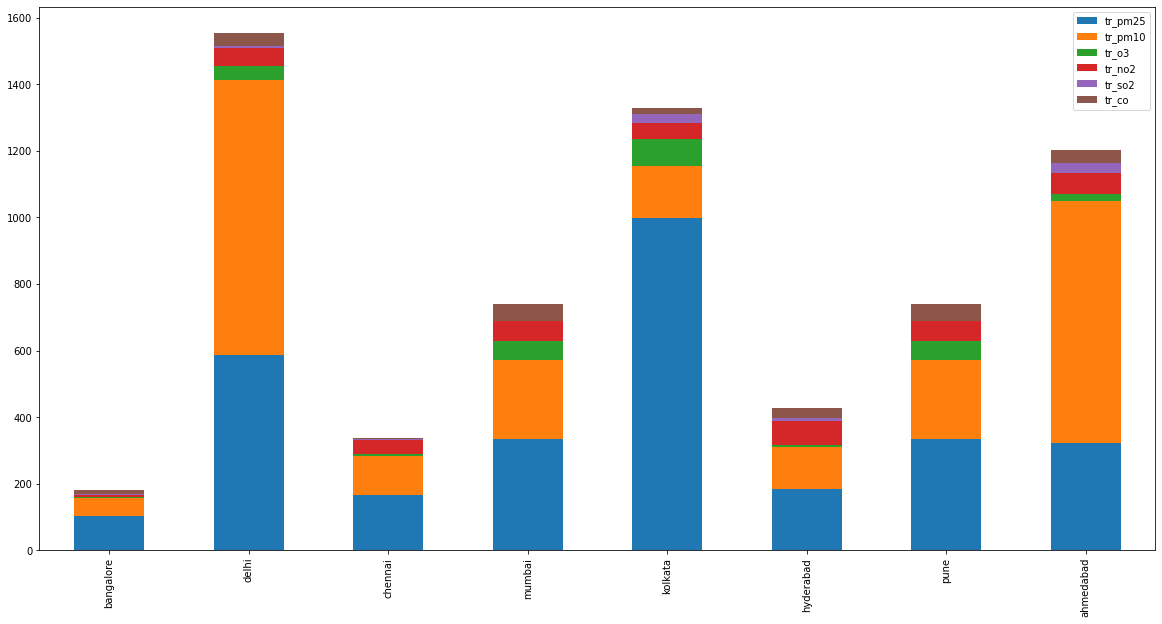

In [10]:
df_pollutants.plot(kind='bar', figsize=(20, 10), stacked=True)

In [11]:
df_pollutants = df_pollutants.replace([math.nan], 0.0)
df_pollutants

,tr_pm25,tr_pm10,tr_o3,tr_no2,tr_so2,tr_co
bangalore,102.0,54.0,4.0,6.0,3.0,13.0
delhi,587.0,826.0,41.0,55.0,6.0,40.0
chennai,166.0,116.0,6.0,43.0,4.0,3.0
mumbai,334.0,237.0,57.0,60.0,0.0,51.0
kolkata,999.0,155.0,82.0,47.0,26.0,19.0
hyderabad,184.0,125.0,8.0,72.0,9.0,29.0
pune,334.0,237.0,57.0,60.0,0.0,51.0
ahmedabad,323.0,726.0,22.0,63.0,29.0,38.0


In [12]:
pca = PCA(n_components=0.9)
transformed = pd.DataFrame(pca.fit_transform(df_pollutants))
key_df = pd.DataFrame(pca.components_)

In [13]:
val_pca = pca.fit_transform(df_pollutants)

In [14]:
pd.DataFrame(transformed.values @ key_df.values + pca.mean_, index=df_pollutants.index, columns=df_pollutants.columns)

,tr_pm25,tr_pm10,tr_o3,tr_no2,tr_so2,tr_co
bangalore,100.977463,52.924221,13.606000,42.885173,2.235733,23.480712
delhi,586.215637,825.596786,46.940391,64.466165,17.962809,44.776012
chennai,164.939928,115.469515,18.412167,44.780076,3.967838,25.193462
mumbai,336.061335,237.561650,31.744644,48.756409,8.209363,28.516169
kolkata,998.482836,154.846265,89.178498,50.729126,19.810874,25.917135
hyderabad,183.231855,125.911463,19.864692,45.142076,4.398600,25.476002
pune,336.061335,237.561650,31.744644,48.756409,8.209363,28.516169
ahmedabad,323.029611,726.128448,25.508965,60.484567,12.205420,42.124337


In [15]:
pd.DataFrame(pca.components_.T, index=df_pollutants.columns)

,0,1
tr_pm25,0.688702,0.719774
tr_pm10,0.722387,-0.690374
tr_o3,0.051236,0.068703
tr_no2,0.021586,-0.012368
tr_so2,0.019075,0.007397
tr_co,0.019804,-0.019543


In [16]:
transformed

,0,1
0,-378.089975,-23.974603
1,517.158389,-206.422119
2,-288.502904,-20.829604
3,-81.537890,18.883186
4,318.075573,556.839550
5,-268.266047,-14.779415
6,-81.537890,18.883186
7,262.700743,-328.600180


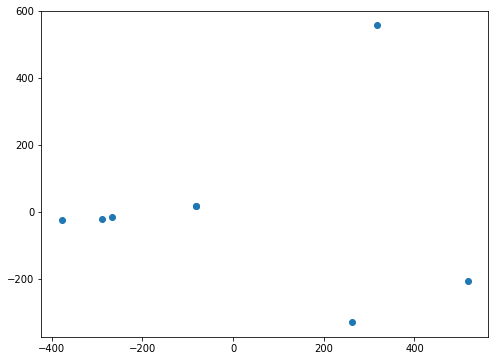

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x=transformed[0], y=transformed[1])

In [18]:
# create a PIIIIIIIIIIIIIIPPPPPPPPPPEEEEEEELIIIIIIINEEEE

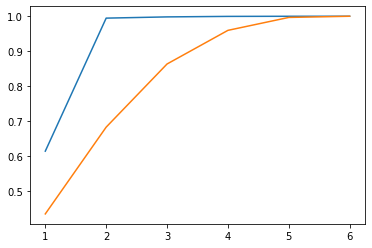

In [19]:
list_num_pc = np.arange(6) + 1
pc_ev = []
for num in list_num_pc:
    pca = PCA(n_components=num)
    transformed = pd.DataFrame(pca.fit_transform(df_pollutants))
    pc_ev.append(sum(pca.explained_variance_ratio_))
plt.plot(list_num_pc, pc_ev)
list_num_pc = np.arange(6) + 1
pc_ev = []
for num in list_num_pc:
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df_pollutants)
    pca = PCA(n_components=num)
    transformed = pd.DataFrame(pca.fit_transform(scaled))
    pc_ev.append(sum(pca.explained_variance_ratio_))
plt.plot(list_num_pc, pc_ev)

In [20]:
df_cities

,tr_pm25,tr_pm10,tr_o3,tr_no2,tr_so2,tr_co,tr_t,tr_h,tr_w,tr_p
bangalore,102.0,54.0,4.0,6.0,3.0,13.0,33.0,93.0,2.0,NaN
delhi,587.0,826.0,41.0,55.0,6.0,40.0,33.0,83.0,2.0,994.0
chennai,166.0,116.0,6.0,43.0,4.0,3.0,31.0,92.0,1.0,787.0
mumbai,334.0,237.0,57.0,60.0,NaN,51.0,30.0,96.0,2.0,953.0
kolkata,999.0,155.0,82.0,47.0,26.0,19.0,29.0,99.0,0.0,1015.0
hyderabad,184.0,125.0,8.0,72.0,9.0,29.0,25.0,53.0,1.0,1019.0
pune,334.0,237.0,57.0,60.0,NaN,51.0,30.0,96.0,2.0,953.0
ahmedabad,323.0,726.0,22.0,63.0,29.0,38.0,34.0,88.0,1.0,1015.0


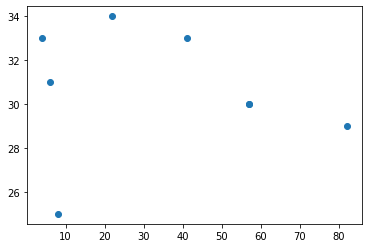

In [30]:
ozone = df_cities['tr_o3'].tolist()
temp = df_cities['tr_t'].tolist()
plt.plot(ozone, temp, 'o')

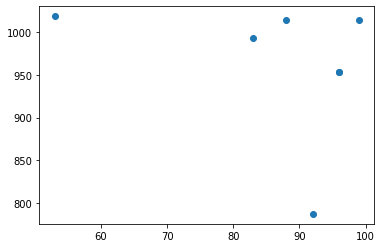

In [37]:
humidity = df_cities['tr_h'].tolist()
pressure = df_cities['tr_p'].tolist()
plt.plot(humidity, pressure, 'o')

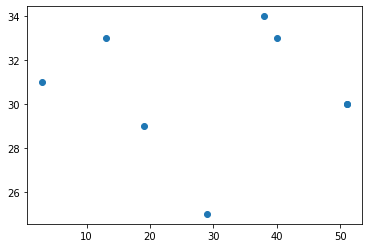

In [39]:
co = df_cities['tr_co'].tolist()
temperature = df_cities['tr_t'].tolist()
plt.plot(co, temperature, 'o')